# TP 3: Hasting-Metropolis (and Gibbs) samplers
<br>
<br>

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from scipy.stats import invwishart
from IPython.display import clear_output
from numpy import log

### Exercise1: Hasting-Metropolis within Gibbs - Stochastic Approximation EM
### 1.A – A population model for longitudinal data

**Question 1**

Let's compute the log-likelihood:

$$log(q(y,z,\theta)) = log(q(y|z, \theta)) + log(q(z|\theta)) + log(q(\theta))$$

Let ${NK} = \sum k_i$


Let'w write all the terms (we leave as constants ($Cst$) all the terms not depending on $y$, $z$, or $\theta$).

<br><br>
$\bullet$ $logq(y|z, \theta)$:

$\forall i, \xi_i \sim \mathcal{N}(0,\sigma)$, and by independance, it comes:
$$\begin{align*} log(q(y|z, \theta)) 
&= \sum_{i=1}^N \sum_{j=1}^{k_i} log(q(\xi_i))  \\
&= - \sum_{i=1}^N \sum_{j=1}^{k_i} \frac{(y_{i,j} - d_i(t_{i,j}))^2}{2\sigma^2} - \frac{NK}{2} log(\sigma^2)   + Cste \end{align*}$$



<br><br>
$\bullet$ $logq(z|\theta)$:
In the same fashion, having:
* $t0 \sim \mathcal{N}( \bar{t_0},\sigma_{t_0})$ 
* $v0 \sim \mathcal{N}(\bar{v_0},\sigma_{v_0})$ 
* $\tau_i \sim \mathcal{N}( 0 ,\sigma_\tau)$ 
* $\xi_i \sim \mathcal{N}( 0 ,\sigma_\xi)$ 

and by independance, it comes:

$$\begin{align*} log \space q(z|\theta) 
&= - \frac{1}{2\sigma_{\xi}^2} \sum_{i=1}^N \xi_i^2  - \frac{1}{2\sigma_{\tau}^2}\sum_{i=1}^N \tau_i^2 - N\log(\sigma_{\tau}) -Nlog(\sigma_{\xi}) - \frac{1}{2\sigma_{t_0}^2} (t_0 -\bar{t_0})^2 - \frac{1}{2\sigma_{v_0}^2} (v_0 -\bar{v_0})^2 
\end{align*}$$




<br><br>
$\bullet$ $logq(\theta)$:

Finally: 
$$\begin{align*} log \space q(z|\theta) 
&= -log(2\pi s_{t_0} s_{v_0}) -\frac{(\bar{t_0}-\bar{\bar{t_0}})^2}{2 s_{t_0}^2} - \frac{(\bar{v_0}-\bar{\bar{v_0}})^2}{2 s_{v_0}^2} \\
&-(1+\frac{m_\xi}{2}) log (\sigma_\xi^2) - \frac{v_\xi^2}{2\sigma_\xi^2} -(1+\frac{m_\tau}{2})log(\sigma_\tau^2) - \frac{v_\tau^2}{2\sigma_\tau^2} -(1+\frac{m}{2}) log( \sigma^2) - \frac{v^2}{2\sigma^2} \\
\end{align*}$$


<br>
<br>
<br>

**In conclusion:**

$$\begin{align*} log \space q(y,z,\theta) &=
- \sum_{i=1}^N \sum_{j=1}^{k_i} \frac{(y_{i,j} - d_i(t_{i,j}))^2}{2\sigma^2} - \frac{NK}{2} log(\sigma^2) \\
& - \frac{1}{2\sigma_{\xi}^2} \sum_{i=1}^N \xi_i^2  - \frac{1}{2\sigma_{\tau}^2}\sum_{i=1}^N \tau_i^2 \\
& - N\log(\sigma_{\tau}) -Nlog(\sigma_{\xi})\\
& - \frac{1}{2\sigma_{t_0}^2} (t_0 -\bar{t_0})^2 - \frac{1}{2\sigma_{v_0}^2} (v_0 -\bar{v_0})^2 - \frac{1}{2}log(s_{t_0}^2) -\frac{1}{2} log(s_{v_0}^2) \\
&-\frac{(\bar{t_0}-\bar{\bar{t_0}})^2}{2 s_{t_0}^2} - \frac{(\bar{v_0}-\bar{\bar{v_0}})^2}{2 s_{v_0}^2} \\
& -(1+\frac{m}{2}) log( \sigma^2) - \frac{v^2}{2\sigma^2} \\
&-(1+\frac{m_\xi}{2}) log (\sigma_\xi^2) \\
&- \frac{v_\xi^2}{2\sigma_\xi^2} -(1+\frac{m_\tau}{2})log(\sigma_\tau^2) - \frac{v_\tau^2}{2\sigma_\tau^2} 
\end{align*}$$



**Let's format $log(q(y,z,\theta))$**, let:

* $S_1 = \frac{1}{NK} \sum_i \sum_{j} (y_{i,j} - d_i(t_{i,j}))^2 $ 
* $S_2 = \frac{1}{N}\sum_{i=1}^N \tau_i^2$ 
* $S_3 = \frac{1}{N}\sum_{i=1}^N \xi_i^2$ 
* $S_4 = t_0$ 
* $S_5 = v_0$ 

and: 
* $\phi_1 = - \frac{NK}{2\sigma ^2}$
* $\phi_2 = -\frac{N}{2 \sigma_{\tau}^2}$
* $\phi_3 = -\frac{N}{2 \sigma_{\xi}^2}$
* $\phi_4 = -\frac{\bar{t_0}}{2\sigma_{t_0}^2}$
* $\phi_5 = -\frac{\bar{v_0}}{2\sigma_{v_0}^2}$

we have: 

$$log(q(y,z,\theta)) = <S| \phi(\theta)> - \psi(\theta)$$

Indeed, we call the remaining part $\psi(\theta)$ and it only depends on  $\theta$.









**Question 2** Let's simulate data. The number of samples per indidual is taken constant equal to `k` for easier computations.

Text(0.5, 0, 'Time')

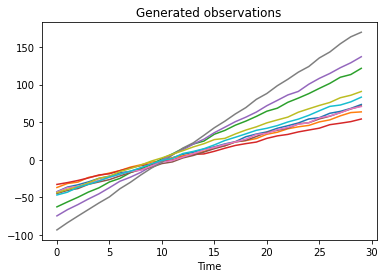

In [3]:
# Parameters
k = 30
N = 10
ts = np.array([i for i in range(k)])

# Model parameters
sigma_t0_true = .1
sigma_v0_true = .2
s_t0 = 3.
s_v0 = 2.
t0_barbare_true = 4
v0_barbare_true = 4.5

# Wishart parameters
m = 2
v = .1
m_tau = 2 
v_tau = .1
m_xi = 2 
v_xi = .1 

# Sample according to previous parameters
t0_bar_true = np.random.normal(t0_barbare_true, s_t0)
v0_bar_true = np.random.normal(v0_barbare_true, s_v0)
t0_true = np.random.normal(t0_bar_true, sigma_t0_true)
v0_true = np.random.normal(v0_bar_true, sigma_v0_true)

sigma_true = np.sqrt(invwishart(m, v).rvs())
sigma_xi_true = np.sqrt(invwishart(m_xi, v_xi).rvs())
sigma_tau_true = np.sqrt(invwishart(m_tau, v_tau).rvs())

xis_true = np.random.normal(0, sigma_xi_true, N)
taus_true = np.random.normal(0,sigma_tau_true,N)

z_true = t0_true, v0_true, xis_true, taus_true
theta_true = t0_bar_true, v0_bar_true,sigma_true, sigma_tau_true, sigma_xi_true

# @jit(nopython=True)
def di(ts, z):
    t0, v0, xis, taus = z
    alphas = np.exp(xis)
    return np.array([v0*(alphas[i]*(ts - t0 - taus[i]) ) for i in range(N)]) 

y = di(ts, z_true) + np.random.normal(0, sigma_true, (N, k))

# Plot
for i in range(10):
    plt.plot(ts, y[i])
plt.title("Generated observations")
plt.xlabel("Time")



In [4]:
print("True t0", t0_true)
print("True v0", v0_true)

True t0 10.349709521338584
True v0 4.183581355033558


### 1.B – HM-SAEM – Hasting-Metropolis sampler

**Question 3.**
<a id='q3'></a>


In [5]:
# from numba import jit

def log_p_tot(y, z, dis, theta, sigma_t0, sigma_v0,):
    """
    Compute simplified log likelihood with terms depending on z only
    """
    t0, v0, xis, taus = z
    t0_bar, v0_bar, sigma, sigma_tau, sigma_xi = theta

    ret = - np.sum(np.square(dis-y))/(2*sigma**2)\
        - np.sum(taus**2)/(2*sigma_tau**2)\
        - np.sum(xis**2)/(2*sigma_xi**2)\
        - ((t0-t0_bar)**2)/(2*sigma_t0**2)\
        - ((v0-v0_bar)**2)/(2*sigma_v0**2)
    return ret


def accept_prop(y, z, z_prop, theta, sigma_t0, sigma_v0):
    """ Computes log likelihoods with z then with z_prop and accept or reject z_prop

    Args:
        y : real data
        z : current z
        z_prop : proposition z
        theta : (t0_bar, v0_bar, sigma, sigma_tau, sigma_xi)
        sigma_t0 
        sigma_v0 

    Returns:
        bool: True if the proposed z is accepted
    """
    # Compute data
    d_prop = di(ts, z_prop)
    d = di(ts, z)

    # Log likelihood
    log_lk_prop = log_p_tot(y, z_prop, d_prop, theta, sigma_t0, sigma_v0)
    log_lk = log_p_tot(y, z, d, theta, sigma_t0, sigma_v0)
    log_alpha = log_lk_prop - log_lk

    return log(np.random.random()) < min(log_alpha, 0)


# @jit(nopython=True)
def hm_sampler(theta, sigma_t0, sigma_v0, y, z_init, n_iter=100, verbose=False):
    """ Samples using Hasting-Metropolis method for the curved exponential family

    Args:
        theta : (t0_bar, v0_bar, sigma, sigma_tau, sigma_xi)
        sigma_t0 : sigma_t0
        sigma_v0 : sigma_v0
        y : real data
        z_init : z parameters to start with
        n_iter : Nuber of iterations. Defaults to 100.
        verbose : Print intermeiate t_0 and v_0. Defaults to False.

    Returns:
        Sampled parameters z = (t0, v0, xis, taus)
    """
    N = y.shape[0]
    z = z_init
    t0, v0, xis, taus = z
    history_log_q = []

    d = di(ts, z)
    log_lk = log_p_tot(y, z, d, theta, sigma_t0, sigma_v0)

    for _i in range(n_iter):
        # Proposition
        sigma_propos = 0.005
        t0_prop = np.random.normal(t0, sigma_propos)
        v0_prop = np.random.normal(v0, sigma_propos)
        xis_prop = np.random.normal(xis, sigma_propos, N)
        taus_prop = np.random.normal(taus, sigma_propos, N)
        z_prop = t0_prop, v0_prop, xis_prop, taus_prop

        if verbose and not _i % 500:
            clear_output(wait=True)
            print(t0, v0)

        if accept_prop(y, z, z_prop, theta, sigma_t0, s_v0):
            # If accept proposition, update z
            t0 = t0_prop
            v0 = v0_prop
            xis = xis_prop.copy()
            taus = taus_prop.copy()
            z = t0, v0, xis, taus

    return (t0, v0, xis, taus)


In [6]:
# Test Hastings-Metropolis sampler with random initialization

# Random initialisations
t0, v0 = np.random.rand(), np.random.rand()
xis = np.random.rand(N)
taus = np.random.rand(N)

z_init= t0, v0, xis, taus

z_estim = hm_sampler(theta_true, sigma_t0_true, sigma_v0_true, y, z_init, n_iter=40000, verbose = True)
dis_estim = di(ts, z_estim)


9.324286936671477 2.387958770612086


In [7]:
print("true t0, v0", t0_true, v0_true)
print("estimated t0, v0", z_estim[0], z_estim[1])

true t0, v0 10.349709521338584 4.183581355033558
estimated t0, v0 9.342649635142411 2.385002576520587


Let's compare the true data with the one generated with obtained parameters (each curve is doubled with its estimated corresponding one).

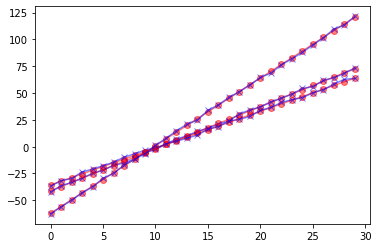

In [8]:
colors = ["red", "green", "blue", "orange"]
for l in range(3):
    plt.plot(ts, dis_estim[l,:], color= "red", alpha = 0.5, marker = 'o')
    plt.plot(ts, y[l,:], color = "blue", alpha = 0.5, marker = 'x')

**Question 4.**
<a id='q4'></a>

We differentiate $\langle S|\phi(\theta) \rangle - \psi(\theta)$  wrt each $\theta$ variable:


$$\nabla_{\bar{t_0}} \langle S| \phi(\theta) \rangle - \psi(\theta) = \frac{S_4}{\sigma_{t_0}^2} - \frac{\bar{t_0}}{\sigma_{t_0}^2} - \frac{1}{\bar{t_0}}{s_{t_0}^2}(\bar{t_0} - \bar{\bar{t_0}})^2$$

And we get:
$$\bar{t_0}^* = \frac{S_4 s_{t_0}^2 + \bar{\bar{t_0}}\sigma_{t_0}^2 }{  s_{t_0}^2 + \sigma_{t_0}^2}$$

In a similar fashion, we get: 
$$\bar{v_0}^* = \frac{S_5 s_{v_0}^2 + \bar{\bar{v_0}}\sigma_{v_0}^2 }{  s_{v_0}^2 + \sigma_{v_0}^2}$$





<br>
Then:

$$\nabla_{\sigma^2}  \langle S| \phi(\theta) \rangle - \psi(\theta) = S_1 \frac{NK}{2 \sigma^4} - \frac{NK}{\sigma^2} -\frac{1 + m/2}{\sigma^2}+ \frac{v^2}{2 \sigma^4}$$

And we get:
$${\sigma^2}^* = \frac{S_1 NK + v 2}{NK + 2 +m}$$
In a similar fashion, we get: 

$${\sigma_{\tau}^2}^* = \frac{S_2N + v_{\tau}^2}{N + 2 +m_{\tau}}$$

$${\sigma^2}^* = \frac{S_1N + v_{\xi}^2}{N + 2 +m_{\xi}}$$


There is a parameter `sampling` for the sampling method because it is needed for later questions (q.7)

In [17]:
def hm_saem(y, theta_init,  n_iter=1000, verbose=False, sampling = "hm"):
    """ Hasting-Metropolis Stochastic Approximation EM algorithm for our curved exponential family case.

    Args:
        y : Real data
        theta_init: Theta to initialize algorithm with
        n_iter : Number of iterations. Defaults to 1000.
        verbose: To print theta during iterations. Defaults to False.
        sampling : Sampler to use. Defaults to "hm".

    Returns:
        Estimated theta
    """
    # Burnout param
    Nb = n_iter//2

    # Init z and S
    t0, v0 = 0., 0.
    xis = np.zeros(N)
    taus = np.zeros(N)
    S, S_new = [0]*5, [0]*5

    alpha = 0.6
    eps = 1

    theta = theta_init
    for iter in range(n_iter):
        ### Simulation ####

        # Question 4
        if sampling == "hm":
            t0, v0, xis, taus = hm_sampler(
                theta, sigma_t0_true, sigma_v0_true, y, (t0, v0, xis, taus), n_iter=30000, verbose=False)
        # Question 7
        elif sampling == "hmwg":
            t0, v0, xis, taus = hmwg_sampler(
                theta, sigma_t0_true, sigma_v0_true, y, (t0, v0, xis, taus), n_iter=30000, verbose=False)
        # Question 9
        elif sampling == "hmwg_block":
            t0, v0, xis, taus = hmwg_sampler(
                theta, sigma_t0_true, sigma_v0_true, y, (t0, v0, xis, taus), n_iter=30000, verbose=False)
        else:
            print("UNKNOWN SAMPLER")
            return
            
        if verbose >= 1:
            print(theta)

        ### Stochatic approx ####
        eps = 1. if i <= Nb else (i-Nb)**-alpha
        d = di(ts,(t0, v0, xis, taus) )

        S_new[0] = np.sum((y-d)**2)/(N*k)
        S_new[1] = np.sum(taus**2)/(N)
        S_new[2] = np.sum(xis**2)/(N)
        S_new[3] = t0
        S_new[4] = v0
        # Update S values
        for j in range(5):
            S[j] = S[j] + eps*(S_new[j]-S[j])

        ### Maximization ####
        sigma = np.sqrt((S[0]*N*k + v**2)/(N*k + 2 + m))
        sigma_tau = np.sqrt((S[1]*N + v_tau**2)/(N + 2 + m_tau))
        sigma_xi = np.sqrt((S[2]*N + v_xi**2)/(N + 2 + m_xi))
        t0_bar = (S[3]*s_t0**2 + t0_barbare_true*sigma_t0_true**2) / (sigma_t0_true**2+s_t0**2)
        v0_bar = (S[4]*s_v0**2 + v0_barbare_true*sigma_v0_true**2) / (sigma_v0_true**2 + s_v0**2)

        theta = t0_bar, v0_bar, sigma, sigma_tau, sigma_xi

    return theta

In [10]:
print( theta_true)

(10.383176170238151, 4.5493524831746255, 0.8804535253273834, 0.507480118413369, 0.31742153454352917)


Let's test the HW SAEM function:

In [12]:
# Define m, v, and a priori
sigma_init = .1
sigma_tau_init = .1
sigma_xi_init = 0.8
t0_bar_init = 3.
v0_bar_init = 3.
theta_init = t0_bar_init, v0_bar_init, sigma_init, sigma_tau_init, sigma_xi_init

print("Truth:")
print( theta_true)
print("Estimates:")
results = hm_saem(y, theta_init, n_iter=6, verbose  = 1)


Truth:
(10.383176170238151, 4.5493524831746255, 0.8804535253273834, 0.507480118413369, 0.31742153454352917)
Estimates:
(3.0, 3.0, 0.1, 0.1, 0.8)
(3.253656499440602, 1.052408847300361, 0.5274414600901103, 0.48660570598619635, 0.2810346455565574)
(5.382278377572832, 1.705642264057943, 0.6673941338173546, 0.6391095616840377, 0.3644667435899991)
(6.750780321217095, 2.1382680834339687, 0.7471943194230806, 0.7592524316020994, 0.409453834022921)
(7.620804093344128, 2.4371353920668057, 0.7895100900665629, 0.8609255436735456, 0.43333165228294757)
(8.158594835660464, 2.601470337314401, 0.8208302341603648, 0.9471802385150357, 0.4562276005843397)


### 1.C – HMwG-SAEM – Hasting-Metropolis within Gibbs sampler

**Question 5, Question 6.**

Below is the HM within Gibbs sampler adapted from the [HM sampler](#q3), but at every iteration, we propose a new $\tau_i$ and $\xi_i$ for all $i$, and a $(t_0,v_0)$.  

In [13]:

def hmwg_sampler(theta,sigma_t0, sigma_v0, y, z_init, n_iter=100, verbose = False):
    t0_bar, v0_bar, sigma, sigma_tau, sigma_xi = theta

    N = y.shape[0]
    t0, v0, xis, taus = z_init

    for iter in range (n_iter):
        sigma_propos = 0.02

        #### Jump on each zi ####
        for i in range(N):
            # Propose xi_i and tau_i
            xis_prop =  xis.copy()
            xis[i] += np.random.normal(0, sigma_propos)
            taus_prop =  taus.copy()
            taus_prop[i] +=  np.random.normal(0,sigma_propos)

            z = (t0, v0, xis, taus)
            z_prop = (t0, v0, xis_prop, taus_prop)
            # If accepted, update components tau_i and xi_i
            if accept_prop(y, z, z_prop, theta, sigma_t0, sigma_v0):
                xis[i] = xis_prop[i]
                taus[i] = taus_prop[i]

        ### Jump on z_pop ###
        t0_prop = np.random.normal(t0, sigma_propos)
        v0_prop =  np.random.normal(v0, sigma_propos)
        z_prop = (t0_prop,v0_prop, xis, taus)
        z = (t0,v0, xis, taus)
        #If accepted, update t0 and v0
        if accept_prop(y, z, z_prop, theta, sigma_t0, sigma_v0):
            t0 = t0_prop
            v0 = v0_prop

        if verbose and not iter%2000:
            print(t0, v0)

    return (t0, v0, taus,  xis)

The new sampler is run on random initialization, the printed values are the evolving t0 and v0 during sampling run.

In [14]:
# Test Hastings-Metropolis sampler

# Random initialisations
z_init= np.random.rand(), np.random.rand(), np.random.rand(N), np.random.rand(N)
print("True v0 and t0")
print(t0_true, v0_true)
print()
result_hm = hmwg_sampler(theta_true, sigma_t0_true, sigma_v0_true, y, z_init, n_iter=30000, verbose = 1)

dis_estim = di(ts, result_hm)


True v0 and t0
10.349709521338584 4.183581355033558

0.7728764970088308 0.7683069731873899
6.709331448950476 2.080454573766594
7.783740127707194 2.1638295927018696
8.589421384039504 2.3052295550101345
9.006604091001705 2.441861354899246
9.462512585807563 2.5417431358055036
9.736570382795676 2.6025015513675918
10.092707875058432 2.6430351666598715
10.190272622183302 2.800874394091904
10.712630952314509 2.766950342971847
10.349570856866602 2.8684233571573583
10.416451805111505 3.0108145673585813
10.439451891837503 3.1936696912235956
10.646068042574715 3.2667185273008665
10.370512519220796 3.533499180186931


**Question 7.**

We used the previous [SAEM function](#q4) and use instead the new Hasting Metropolis within Gibb sampler.
I printed true theta values, then the evolving estimates during algorithm run.


In [16]:
print("Truth:")
print( theta_true)
print("Estimates:")
results = hm_saem(y, theta_init, n_iter=15, verbose  = 1, sampling="hmwg")

Truth:
(10.383176170238151, 4.5493524831746255, 0.8804535253273834, 0.507480118413369, 0.31742153454352917)
Estimates:
(3.0, 3.0, 0.1, 0.1, 0.8)
(5.1425000057387065, 1.1473039321832916, 221.38943544792838, 0.7424288078579058, 1.8262842420280272)
(5.21760377979217, 1.1141577212630445, 132.9710570109091, 0.7532504284924969, 1.1531013317438454)
(5.16484750409556, 1.1847197633363222, 83.45904813650942, 0.7171396105837348, 0.9364091392692898)
(5.117363598706543, 1.472779158447051, 57.280018965178854, 0.6688613688686216, 0.7071582936664669)
(5.154490018719984, 1.8256102020521578, 39.70149332343704, 0.6136307975943324, 0.6576814725326956)
(5.14541899835676, 1.9014281796937722, 34.60914976458088, 0.5616493652848187, 0.6755521028268044)
(5.105013266626459, 2.0482271395127434, 29.45568313923762, 0.5187952203306174, 0.5915494034947066)
(5.217181127845715, 2.3307782031341153, 28.80130842476561, 0.4521160049296098, 0.5602191150842666)
(5.371343205322552, 2.4180545857633797, 27.052060039259977, 0.43

I did not have time to investigate further but with this sampler, the convergence seem a little difficult. Also, run time is very long with uncompiled python.

**Question 8**

The above sampler has the disadvatage to be significantely slower. Indeed, at each iteration, it does the same amount of computation for every variable, which can be very slow for big number of individuals.
Thus the block sampler could be much more efficient in terms of computation time.

**Question 9**

In [18]:

def hmwg_block_sampler(theta,sigma_t0, sigma_v0, y, z_init, n_iter=100, verbose = False):

    N = y.shape[0]
    t0, v0, xis, taus = z_init

    for iter in range (n_iter):
        sigma_propos = 0.02

        #### Jump on the block of individuals ####
        xis_prop =  np.random.normal(xis, sigma_propos)
        taus_prop =  np.random.normal(taus,sigma_propos)

        z = (t0, v0, xis, taus)
        z_prop = (t0, v0, xis_prop, taus_prop)
        # If accepted, update tas and xis
        if accept_prop(y, z, z_prop, theta, sigma_t0, sigma_v0):
            xis = xis_prop.copy()
            taus = taus_prop.copy()

        ### Jump on z_pop ###
        t0_prop = np.random.normal(t0, sigma_propos)
        v0_prop =  np.random.normal(v0, sigma_propos)
        z_prop = (t0_prop,v0_prop, xis, taus)
        z = (t0,v0, xis, taus)
        #If accepted, update t0 and v0
        if accept_prop(y, z, z_prop, theta, sigma_t0, sigma_v0):
            t0 = t0_prop
            v0 = v0_prop

        if verbose and not iter%2000:
            print(t0, v0)

    return (t0, v0, taus,  xis)

We try our block sampler.

In [ ]:
print("Truth:")
print( theta_true)
print("Estimates:")
results = hm_saem(y, theta_init, n_iter=15, verbose  = 1, sampling="hmwg_block")

I did not have time to test the block sampler, unfortunately.

---
---

### Exercise 3: Data augmentation

**Question 1.**
We have that:
$$X_n \sim f_{X|Y}( \cdot,Y_{n−1})$$
$$Y_n \sim f_{Y|X}(X_n, \cdot)$$


For $A \in \mathcal{P}(\mathbb{R}^p \times \mathbb{R}^n$):

$$\mathbb{P}((X_n, Y_n) \in A) = \int f(x,y)dxdy$$

We want to express all quantities only wrt previous states. <br>
Let's write the definition of $Y|X = x$ and then ,using that $f_{X_n} = f_{X|Y}( \cdot,Y_{n−1})$, it comes that:
$$f(x,y) = f_{Y|X_n = x}(y) f_{X|Y_{n-1}}(x) $$


Thus: 
$$\mathbb{P}((X_n, Y_n) \in A) = \int f_{Y|X_n = x}(y) f_{X|Y_{n-1}}(x) dxdy $$

Thus, the bivariate chain $(X_n, Y_n)$ is a Markov chain, and it's kernel is given by $f_{Y|X_n = x}(y) f_{X|Y_{n-1}}(x)$

**Question 2.**



**Question 3.**

The Gibbs sampler samples $u^{(k)}$ by sequentially sampling $u_l^{(k)}$ from $\pi_i(u_l|u_1^{(k+1)}...u_{l-1}^{(k+1)},u_{l+1}^{(k)}...u_{n}^{(k)})$.

Thus, here, with two components, it is necessary to know $f_{X|Y}$ and $f_{Y|X}$.

Let's identify the densities $f_{X,Y}$ and $f_X$ and $f_Y$, using the law of $(X,Y)$



*On one hand:*
$$f_{X|Y=y}(x)=  \frac{f_{X,Y}(x,y)}{f_Y(y)}$$
$$f_{X|Y=y}(x) \propto  e^{ -y x^2 } $$
$$f_{X|Y=y}(x) \propto  e^{\frac{x^2}{2 \frac{1}{y}} } $$

Thus, we identify the following Normal law:
$$ X|(Y=y) \sim \mathcal{N}( 0,  \frac{1}{y})$$

*On the other hand:*
$$f_{Y|X=x}(y)=  \frac{f_{X,Y}(x,y)}{f_X(x)}$$
$$f_{Y|X=x}(y) \propto  y^{\frac{3}{2}} exp(-y(\frac{x^2}{2} +2))  $$
$$f_{Y|X=x}(y) \propto  y^{\frac{5}{2} - 1} exp(-y(\frac{x^2}{2} +2))  $$

Thus, we identify the following Gamma law:
$$ Y|(X=x) \sim \Gamma( \frac{5}{2},\frac{x^2}{2} +2)$$







**Question 4.**

We can make the Gibbs sampler as follows, because we know $f_{X|Y}$ and $f_{Y|X}$ from the previous question.

At each step `n`:
*  Sample $x^{(n+1)}$ from $f_{X|Y = y^{(n)}}$ 
*  Sample $y^{(n+1)}$ from $f_{Y|X = x^{(n+1)} }$


In [ ]:
# Gibbs sampler
def gibbs_sampler(x_start, y_start, N):
    # Init samples
    s = np.zeros((N,2))
    s[0,:] = [x_start, y_start]
    
    for i in range(1, N):
        # Use previous y sample to compute x
        y_previous = s[i-1,1]
        x= np.random.normal(0, 1/np.sqrt(y_previous))
        # Use current x to compute y
        y = s[i,1] = np.random.gamma(5./2, 1/(0.5*x**2 + 2))

        s[i, 0] = x
        s[i, 1] = y

    return s

In [ ]:
# Sample using function
samples = gibbs_sampler(1, 3, 1000000)

Let's see show the distributions along each variable look like:

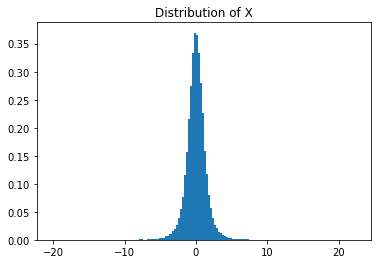

In [ ]:
plt.hist(samples[:,0], bins = 150, density = True)
plt.title("Distribution of X")
plt.show()

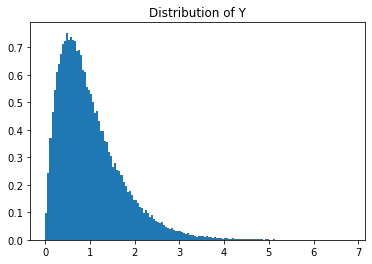

In [ ]:
plt.hist(samples[:,1], bins = 150, density=True)
plt.title("Distribution of Y")
plt.show()

Let's scatter the distribution of the samples for both variables:

Text(0, 0.5, 'y')

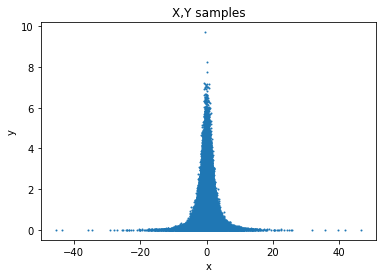

In [ ]:
plt.scatter(samples[:,0], samples[:,1], s = 1)
plt.title ("X,Y samples")
# plot_lin = np.linspace(-20,20, 1000)
# plt.plot(plot_lin, 1/abs(plot_lin) , color = "red")
plt.xlabel("x")
plt.ylabel("y")

Let's plot all sample whose y values are in $[3, 3.1]$, to check and compare it with a gaussian of standard deviation $\frac{1}{\sqrt{3.05}}$ (the law it should follow).

In [ ]:
from scipy.stats import norm

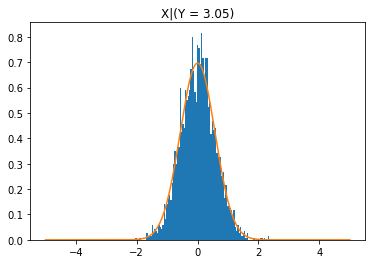

In [ ]:
sub_samples =samples[np.where(np.logical_and( samples[:,1]>=3, samples[:,1] <=3.1)), 0]

plt.hist(sub_samples.reshape((-1)), bins = 100, density = True)
plot_lin = np.linspace(-5,5, 1000)
plt.plot(plot_lin, norm.pdf(plot_lin, loc = 0, scale = 1/3.05**0.5))
plt.title("X|(Y = 3.05)")
plt.show()

As expected the samples follow the conditional law of $X|(Y=3.05)$.